# 0.  Generate Score in Games

In order to determine the outcome of a node (chessboard state), we use the stockfish engine to evaluate its score. A higher score indicates a greater likelihood of winning, and typically, a score above 200 can be considered a victory.

In [93]:
import chess.engine
import matplotlib.pyplot as plt
import pandas as pd
import time
import chess.pgn

def evaluate_game(game, engine):
    # to save the scores
    scores = []

    # initial the board
    board = game.board()
    info = engine.analyse(board, chess.engine.Limit(time=0.001))
    score = info["score"].relative.score()
    scores.append(score)
    
    for move in game.mainline_moves():
        board.push(move)
        info = engine.analyse(board, chess.engine.Limit(time=0.001))
        score = info["score"].relative.score()
        scores.append(score)

    return scores

def games_scores(games):
    # initial the engine
    engine = chess.engine.SimpleEngine.popen_uci("stockfish\stockfish-windows-x86-64.exe")
    
    for i, game in enumerate(games):
        scores = evaluate_game(game, engine)
        game_scores[f'game_{i+1}'] = scores


    # close the engine
    engine.quit()

s = time.time()

games = []

# read games
with open('100games.pgn', 'r', encoding='utf-8') as f:
    while True:
        game = chess.pgn.read_game(f)
        if game is None:
            break  
        games.append(game)

game_scores = {}    

games_scores(games)


df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in game_scores.items() ]))

# save the data
df.to_excel('100scores0.001.xlsx', index=False)

print((time.time()-s)/len(games))


0.25305402994155884


# 0. Generate Change Points of Scores

In order to distinguish the opening, middle, and end stages of a game, we require a division of the game into phases based on scores. The following code will generate change points for each game.

In [1]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import time

s = time.time()

# Read Excel data
df = pd.read_excel('100scores0.001.xlsx')

# Define the size of the sliding window
window_size = 5

# List to store transition points
transition_points_data = []

# Process each game
for column in df.columns:
    series = df[column].dropna()  # Remove null values
    # Calculate the rolling window average
    rolling_mean = series.rolling(window=window_size).mean()
    
    # Find the local maxima
    maxima = argrelextrema(rolling_mean.values, np.greater)[0]

    # Find the two consecutive local maxima with the greatest difference
    if len(maxima) < 2:
        print(f'Found less than 2 maxima for series {column}')
        data = {'Series': column, 'Transition Point 1': maxima[0] if len(maxima) > 0 else np.nan, 'Transition Point 2': np.nan}
    else:
        diff = np.diff(rolling_mean.values[maxima])
        max_diff_indexes = np.argsort(diff)[-2:]
        transition_points = maxima[max_diff_indexes]
        transition_points = np.sort(transition_points)  # Ensure points are in order
        # Create a dictionary to store the game's name and transition points
        data = {'Series': column, 
                'Transition Point 1': transition_points[0] if len(transition_points) > 0 else np.nan, 
                'Transition Point 2': transition_points[1] if len(transition_points) > 1 else np.nan}

    transition_points_data.append(data)

# Convert the list to a DataFrame and save it as an Excel file
transition_points_df = pd.DataFrame(transition_points_data)
transition_points_df.to_excel('100scores0.001_change_points.xlsx', index=False)

print(time.time()-s)


Found less than 2 maxima for series game_77
Found less than 2 maxima for series game_79
2.378504514694214


# 1. Opening and End Games

## Construct the Graph for Matches

In [5]:
import pandas as pd
import networkx as nx
import numpy as np
import chess.pgn
import time

# Read Excel data
score_df = pd.read_excel('100scores0.001.xlsx')
transition_df = pd.read_excel('100scores0.001_change_points.xlsx')
transition_df.set_index('Series', inplace=True)

s = time.time()

# Create a directed graph
G = nx.DiGraph()

# Dictionary to store scores for each fen state across different games
fen_scores = {}

# Process each game
for game_idx, game in enumerate(games):
    # Get the fen state sequence from the game object
    board = game.board()
    fen_sequence = [board.fen()]
    for move in game.mainline_moves():
        board.push(move)
        fen_sequence.append(board.fen())
    
    # Get transition points
    if 'game_'+str(game_idx+1) in transition_df.index and not transition_df.loc['game_'+str(game_idx+1)].isna().any():
        transition_points = transition_df.loc['game_'+str(game_idx+1)]
    else:
        continue  # Skip games with missing data

    # Determine the stage of each fen state
    for i, fen in enumerate(fen_sequence):
        if i == 0:
            stage = '0'
        elif i < transition_points['Transition Point 1']:
            stage = '1'
        elif i < transition_points['Transition Point 2']:
            stage = '2'
        elif i < len(fen_sequence) - 1:
            stage = '3'
        else:
            stage = '4'

        # Update scores for fen state across different games
        if i < len(score_df):
            score = score_df.loc[i, 'game_'+str(game_idx+1)]
        else:
            continue  # Skip steps not present in score_df

        if np.isnan(score):
            continue

        if fen not in fen_scores:
            fen_scores[fen] = [score]
        else:
            fen_scores[fen].append(score)

        # Calculate winning condition
        avg_score = np.mean(fen_scores[fen])
        win = 1 if avg_score > 200 else 0

        # If fen state is not in the graph, create a new node
        if fen not in G.nodes:
            G.add_node(fen, win=win, cat=stage, who='1' if i % 2 == 0 else '0')
        else:  # Otherwise, update the node's winning condition
            G.nodes[fen]['win'] = win

        # If not the first step, create an edge from the previous fen state to the current fen state and update the weight
        if i > 0:
            prev_fen = fen_sequence[i - 1]
            if G.has_edge(prev_fen, fen):
                G[prev_fen][fen]['weight'] += 1
            else:
                G.add_edge(prev_fen, fen, weight=1)

# Check and remove nodes without all attributes
nodes_to_remove = []
for node in G.nodes(data=True):
    if 'win' not in node[1] or 'cat' not in node[1] or 'who' not in node[1]:
        nodes_to_remove.append(node[0])

for node in nodes_to_remove:
    G.remove_node(node)

during = time.time()-s
print(during/len(games))


0.00572101354598999


In [6]:
# print the number of nodes and edges
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# save the graph
nx.write_gpickle(G, '100graph1.gpickle')

Number of nodes: 5830
Number of edges: 5801


## Node2vec

In [98]:
import time
import networkx as nx
import pandas as pd
import numpy as np
from node2vec import Node2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

s = time.time()

# load the graph
G = nx.read_gpickle('100graph1.gpickle')

# initial node2vec
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=16)

# train node2vec
model = node2vec.fit(window=10, min_count=1, batch_words=4)

print(time.time()-s)


Computing transition probabilities:   0%|          | 0/5830 [00:00<?, ?it/s]

879.6913452148438


In [99]:
# get node2vec data
nodes = [x for x in G.nodes(data=True)]
node_ids = [x[0] for x in nodes]
node_features = np.array([model.wv[x] for x in node_ids])

# generate the data for node classification
df = pd.DataFrame(node_features, index=node_ids)
for node_id, node_data in nodes:
    if 'who' in node_data:
        df.loc[node_id, 'who'] = node_data['who']
    if 'cat' in node_data:
        df.loc[node_id, 'cat'] = node_data['cat']
    if 'win' in node_data:
        df.loc[node_id, 'win'] = node_data['win']



In [100]:
# save the data
df.to_excel('1_100_graph_1.xlsx')

## Model Building

### Random Forest

In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import time
import torch

# read the data
df = pd.read_excel('1_100_graph_1.xlsx', index_col=0)

# one-hot coding
cat_ohe = OneHotEncoder(drop='first', sparse=False)
cat_encoded = cat_ohe.fit_transform(df[['cat']])
cat_encoded_df = pd.DataFrame(cat_encoded, columns=[f'cat_{cat}' for cat in range(1, 5)], index=df.index)

df = pd.concat([df, cat_encoded_df], axis=1)

# get X and y
X = df.drop(columns=['win', 'cat'])
y = df['win']
cat_data = df['cat']  
who_data = df['who']

X.columns = X.columns.astype(str)

# split training and test data
X_train, X_test, y_train, y_test, cat_train, cat_test, who_train, who_test = train_test_split(X, y, cat_data, who_data, test_size=0.2, random_state=42)

# build and train the model
model = RandomForestClassifier(n_jobs=-1, random_state=42)
start = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start

# evaluate on test data
y_train_pred = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]

# result dataframe
results = pd.DataFrame({
    'who': pd.concat([df['who'].loc[X_train.index], df['who'].loc[X_test.index]]),
    'win_probability': np.concatenate([y_train_pred, y_test_pred]),
    'cat': pd.concat([df['cat'].loc[X_train.index], df['cat'].loc[X_test.index]]),
    'is_test': np.concatenate([np.zeros(len(y_train), dtype=int), np.ones(len(y_test), dtype=int)])
})

# save to excel
results.to_excel('1_node_random_forest_result.xlsx')

# calculate the accuracy of training and test data
train_acc = accuracy_score(y_train, y_train_pred > 0.5)
test_acc = accuracy_score(y_test, y_test_pred > 0.5)

# classification report
train_report = classification_report(y_train, y_train_pred > 0.5)
test_report = classification_report(y_test, y_test_pred > 0.5)

print(f"Train Accuracy: {train_acc}\n")
print(f"Test Accuracy: {test_acc}\n")
print(f"Training Time: {training_time} seconds\n")

print("Train Classification Report:\n", train_report)
print("Test Classification Report:\n", test_report)

# save the results
with open('1_node_random_forest_result.txt', 'w') as f:
    f.write(f"Train Accuracy: {train_acc}\n")
    f.write(f"Test Accuracy: {test_acc}\n")
    f.write(f"Training Time: {training_time} seconds\n")

    f.write("Train Classification Report:\n")
    f.write(train_report)
    
    f.write("Test Classification Report:\n")
    f.write(test_report)


D:\ProgramData\anaconda3\envs\8021a3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Train Accuracy: 1.0

Test Accuracy: 0.7272727272727273

Training Time: 0.4422180652618408 seconds

Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3477
           1       1.00      1.00      1.00      1187

    accuracy                           1.00      4664
   macro avg       1.00      1.00      1.00      4664
weighted avg       1.00      1.00      1.00      4664

Test Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.97      0.84       856
           1       0.39      0.05      0.08       310

    accuracy                           0.73      1166
   macro avg       0.56      0.51      0.46      1166
weighted avg       0.65      0.73      0.64      1166



### Gradient Boosting

In [102]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import time
import torch

# read the data
df = pd.read_excel('1_100_graph_1.xlsx', index_col=0)

# one hot
cat_ohe = OneHotEncoder(drop='first', sparse=False)
cat_encoded = cat_ohe.fit_transform(df[['cat']])
cat_encoded_df = pd.DataFrame(cat_encoded, columns=[f'cat_{cat}' for cat in range(1, 5)], index=df.index)

df = pd.concat([df, cat_encoded_df], axis=1)

# get X and y
X = df.drop(columns=['win'])
y = df['win']
cat_data = df['cat']  
who_data = df['who']

X.columns = X.columns.astype(str)

# split training and test data
X_train, X_test, y_train, y_test, cat_train, cat_test, who_train, who_test = train_test_split(X, y, cat_data, who_data, test_size=0.2, random_state=42)

# build and train the model
model = GradientBoostingClassifier(random_state=42)
start = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start

# evaluate on test data
y_train_pred = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]

# save the results
results = pd.DataFrame({
     'who': pd.concat([df['who'].loc[X_train.index], df['who'].loc[X_test.index]]),
    'win_probability': np.concatenate([y_train_pred, y_test_pred]),
    'cat': pd.concat([df['cat'].loc[X_train.index], df['cat'].loc[X_test.index]]),
    'is_test': np.concatenate([np.zeros(len(y_train), dtype=int), np.ones(len(y_test), dtype=int)])
})

results.to_excel('1_node_gradient_boosting_result.xlsx')

train_acc = accuracy_score(y_train, y_train_pred > 0.5)
test_acc = accuracy_score(y_test, y_test_pred > 0.5)

train_report = classification_report(y_train, y_train_pred > 0.5)
test_report = classification_report(y_test, y_test_pred > 0.5)

print(f"Train Accuracy: {train_acc}\n")
print(f"Test Accuracy: {test_acc}\n")
print(f"Training Time: {training_time} seconds\n")

print("Train Classification Report:\n", train_report)
print("Test Classification Report:\n", test_report)

# save the results
with open('1_node_gradient_boosting_result.txt', 'w') as f:
    f.write(f"Train Accuracy: {train_acc}\n")
    f.write(f"Test Accuracy: {test_acc}\n")
    f.write(f"Training Time: {training_time} seconds\n")

    f.write("Train Classification Report:\n")
    f.write(train_report)
    
    f.write("Test Classification Report:\n")
    f.write(test_report)


D:\ProgramData\anaconda3\envs\8021a3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Train Accuracy: 0.8055317324185248

Test Accuracy: 0.7152658662092625

Training Time: 10.406635522842407 seconds

Train Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88      3477
           1       0.95      0.25      0.39      1187

    accuracy                           0.81      4664
   macro avg       0.87      0.62      0.64      4664
weighted avg       0.84      0.81      0.76      4664

Test Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.95      0.83       856
           1       0.31      0.06      0.10       310

    accuracy                           0.72      1166
   macro avg       0.52      0.51      0.46      1166
weighted avg       0.62      0.72      0.64      1166



### GCN

In [103]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import from_networkx
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import networkx as nx
import json
import numpy as np
import time
from sklearn.metrics import accuracy_score

G = nx.read_gpickle("100graph1.gpickle")

# Prepare your node features and labels
num_nodes = len(G)
x = torch.zeros((num_nodes, 7))  # 7 features, cat(5), who(1), edge weights(1)
y = torch.zeros(num_nodes, dtype=torch.float)  # float for BCELoss

for i, (node, data) in enumerate(G.nodes(data=True)):
    cat_vector = [0, 0, 0, 0, 0]
    cat_vector[int(data['cat'])] = 1
    who = 1 if data['who'] == '1' else 0  # assuming 'who' is either 'black' or 'white'
    x[i] = torch.tensor(cat_vector + [who, G.degree(node, weight='weight')])
    y[i] = data['win']

# Convert the NetworkX graph to a PyG Data object
data = from_networkx(G)
data.edge_attr = torch.tensor([data['weight'] for _, _, data in G.edges(data=True)], dtype=torch.float32).view(-1, 1)

data.x = x
data.y = y

# Split the data into training and test sets
train_mask = torch.rand(num_nodes) < 0.8
data.train_mask = train_mask
data.test_mask = ~train_mask


In [104]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(7, 64)  # input has 7 features
        self.conv2 = GCNConv(64, 64)
        self.conv3 = GCNConv(64, 32)
        self.conv4 = GCNConv(32, 1)  # output for binary classification

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index, edge_weight)
        return torch.sigmoid(x)  # Sigmoid for binary classification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train_and_eval():
    model.train()
    optimizer.zero_grad()
    out = model(data).view(-1)
    loss = F.binary_cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    pred = (out > 0.5).long()
    train_correct = pred[data.train_mask] == data.y[data.train_mask]
    train_acc = train_correct.sum().item() / data.train_mask.sum().item()
    return loss.item(), train_acc

def test():
    model.eval()
    with torch.no_grad():
        predictions = model(data).view(-1)
        predictions = (predictions > 0.5).long()
        correct = predictions[data.test_mask] == data.y[data.test_mask]
        test_acc = correct.sum().item() / data.test_mask.sum().item()
    return test_acc


s = time.time()
# Training loop
best_acc = 0
for epoch in range(200):
    loss, train_acc = train_and_eval()
    test_acc = test()
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pt')
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Loss {loss:.4f}, Train Acc {train_acc:.4f}, Test Acc {test_acc:.4f}')

training_time = time.time() - s

# Load best model for evaluation
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
out = model(data).view(-1)
pred = (out > 0.5).long()  # convert probabilities to binary outputs

# Compute classification report for both train and test
train_classification_rep = classification_report(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu())
test_classification_rep = classification_report(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())

# Print classification reports
print('\nTrain Classification Report:\n')
print(train_classification_rep)
print('\nTest Classification Report:\n')
print(test_classification_rep)
print('\nBest Test Accuracy: ' + str(best_acc))
print('\nTraining Time: ' + str(training_time) + ' seconds\n')

# Save results to file
with open('1_node_gcn_result.txt', 'w') as f:
    f.write('\nTrain Classification Report:\n')
    f.write(train_classification_rep)
    f.write('\nTest Classification Report:\n')
    f.write(test_classification_rep)
    f.write('\nBest Test Accuracy: ' + str(best_acc))
    f.write('\nTraining Time: ' + str(training_time) + ' seconds\n')


Epoch 0: Loss 2.0102, Train Acc 0.2842, Test Acc 0.7293
Epoch 10: Loss 0.5454, Train Acc 0.7468, Test Acc 0.7293
Epoch 20: Loss 0.5441, Train Acc 0.7468, Test Acc 0.7293
Epoch 30: Loss 0.5400, Train Acc 0.7468, Test Acc 0.7293
Epoch 40: Loss 0.5332, Train Acc 0.7468, Test Acc 0.7293
Epoch 50: Loss 0.5320, Train Acc 0.7468, Test Acc 0.7293
Epoch 60: Loss 0.5318, Train Acc 0.7468, Test Acc 0.7293
Epoch 70: Loss 0.5312, Train Acc 0.7468, Test Acc 0.7293
Epoch 80: Loss 0.5307, Train Acc 0.7468, Test Acc 0.7293
Epoch 90: Loss 0.5311, Train Acc 0.7468, Test Acc 0.7293
Epoch 100: Loss 0.5304, Train Acc 0.7468, Test Acc 0.7293
Epoch 110: Loss 0.5298, Train Acc 0.7468, Test Acc 0.7293
Epoch 120: Loss 0.5273, Train Acc 0.7468, Test Acc 0.7293
Epoch 130: Loss 0.5280, Train Acc 0.7468, Test Acc 0.7293
Epoch 140: Loss 0.5263, Train Acc 0.7468, Test Acc 0.7293
Epoch 150: Loss 0.5277, Train Acc 0.7468, Test Acc 0.7293
Epoch 160: Loss 0.5269, Train Acc 0.7468, Test Acc 0.7293
Epoch 170: Loss 0.5281, T

D:\ProgramData\anaconda3\envs\8021a3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\anaconda3\envs\8021a3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\anaconda3\envs\8021a3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\anac

## CNN

In [105]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import time


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*16, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.relu(x))
        x = self.conv2(x)
        x = self.pool(F.relu(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = pd.read_excel('1_100_graph_1.xlsx')

cat_ohe = OneHotEncoder(drop='first', sparse=False)
cat_encoded = cat_ohe.fit_transform(df[['cat']])
cat_encoded_df = pd.DataFrame(cat_encoded, columns=[f'cat_{cat}' for cat in range(1, 5)], index=df.index)

df = pd.concat([df, cat_encoded_df], axis=1)

X = df.drop(columns=['win'])

X = df.iloc[:, 1:65].values
y = df['win'].values
names = df.iloc[:, 0].values
cat = df['cat'].values

X_train, X_test, y_train, y_test, names_train, names_test, cat_train, cat_test = train_test_split(X, y, names, cat, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

best_acc = 0
start_time = time.time()

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train).squeeze()
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs = model(X_test).squeeze()
        preds = (outputs > 0.5).float()
        acc = (preds == y_test).float().mean()

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model.pt')

elapsed_time = time.time() - start_time

model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    outputs = model(X_test).squeeze()
    preds = (outputs > 0.5).float()

classification_rep = classification_report(y_test.cpu().numpy(), preds.cpu().numpy())

# result_df = pd.DataFrame({'node': names_test, 'win_probability': outputs.cpu().numpy(), 'is_test': True, 'cat': cat_test})
# result_df.to_excel('1-node_cnn_result.xlsx', index=False)


print('Classification Report:\n')
print(classification_rep)
print('\nTest Accuracy: ' + str(best_acc.item()))
print('\nTraining Time: ' + str(elapsed_time) + ' seconds\n')
with open('1_node_cnn_result.txt', 'w') as f:
    f.write('Classification Report:\n')
    f.write(classification_rep)
    f.write('\nTest Accuracy: ' + str(best_acc.item()))
    f.write('\nTraining Time: ' + str(elapsed_time) + ' seconds\n')


D:\ProgramData\anaconda3\envs\8021a3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Classification Report:

              precision    recall  f1-score   support

         0.0       0.73      1.00      0.85       856
         1.0       0.00      0.00      0.00       310

    accuracy                           0.73      1166
   macro avg       0.37      0.50      0.42      1166
weighted avg       0.54      0.73      0.62      1166


Test Accuracy: 0.7341338396072388

Training Time: 2.0694563388824463 seconds



D:\ProgramData\anaconda3\envs\8021a3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\anaconda3\envs\8021a3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\anaconda3\envs\8021a3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


After running the above code, we will obtain an Excel file containing the columns 'nodes name', 'probabilities', and 'cat'. This Excel file represents the final outcome.

# 2. Middle Games

## 2.1 Comminity Detection

### Construt the Graph for Players

In [206]:
import networkx as nx

# create a directed graph
G = nx.DiGraph()

games = []

# read games
with open('10000games.pgn', 'r', encoding='utf-8') as f:
    while True:
        game = chess.pgn.read_game(f)
        if game is None:
            break  
        games.append(game)

# Utilize two dictionaries to track each player's current Elo rating and the number of victories they have against each opponent.
elo_scores = {}
wins = {}

# loop in games
for game in games:
    # get players' names
    white = game.headers["White"]
    black = game.headers["Black"]

    # get the changes in elo
    white_diff = int(game.headers.get("WhiteRatingDiff", 0))
    black_diff = int(game.headers.get("BlackRatingDiff", 0))

    # updata elo 
    elo_scores[white] = int(game.headers["WhiteElo"]) + white_diff
    elo_scores[black] = int(game.headers["BlackElo"]) + black_diff

    # get the game result
    result = game.headers["Result"]

    # Update the victory count based on the game results.
    if result == "1-0":  # if white wins
        wins[(white, black)] = wins.get((white, black), 0) + 1
    elif result == "0-1":  # if black wins
        wins[(black, white)] = wins.get((black, white), 0) + 1

# Create nodes and edges for a graph using the latest Elo scores and the difference in the number of victories.
for player, elo in elo_scores.items():
    G.add_node(player, elo=elo)
for players, win_count in wins.items():
    player1, player2 = players
    net_wins = win_count - wins.get((player2, player1), 0)
    if net_wins > 0:
        G.add_edge(player1, player2, weight=net_wins)
    elif net_wins < 0:
        G.add_edge(player2, player1, weight=-net_wins)


In [183]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

nx.write_gpickle(G, '10000graph2.gpickle')

Number of nodes: 12013
Number of edges: 8787


### Model

#### Louvain

In [60]:
import networkx as nx
import igraph as ig
import leidenalg
import matplotlib.pyplot as plt
import pandas as pd
import time
from collections import defaultdict

def convert_networkx_to_igraph(nx_graph):
    '''convert networkx graph to igraph graph'''
    mapping = dict(zip(nx_graph, range(nx_graph.number_of_nodes())))
    reverse_mapping = dict(zip(range(nx_graph.number_of_nodes()), nx_graph))
    ig_graph = ig.Graph(edges=[(mapping[e[0]], mapping[e[1]]) for e in nx_graph.edges()], directed=False)
    ig_graph.es['weight'] = [e['weight'] for e in nx_graph.edges().values()]
    return ig_graph, mapping, reverse_mapping


# read the data
G = nx.read_gpickle('10000graph2.gpickle')

# convert networkx graph to igraph graph
ig_graph, mapping, reverse_mapping = convert_networkx_to_igraph(G)

s = time.time()

# build and train the model
partition = leidenalg.find_partition(ig_graph, leidenalg.CPMVertexPartition, 
                                     resolution_parameter = 1e-20, 
                                     weights=ig_graph.es['weight'], 
                                     )

during = time.time() - s
print('Running time: {}s\n'.format(during))
print(f'Number of communities: {len(set(partition.membership))}\n')

# Convert the community detection results into attributes of networkx graph nodes.
for i, community in enumerate(partition):
    for node in community:
        G.nodes[reverse_mapping[node]]['community'] = i

# Calculate and output the variance of Elo scores for each player within each community.
community_Elo = defaultdict(list)
for node, data in G.nodes(data=True):
    community_Elo[data['community']].append(data['elo'])
variance_sum = sum(np.var(Elo) for Elo in community_Elo.values())
print('The sum of variances of Elo within each community is', variance_sum)

# Save the classification results as an xlsx file.
df = pd.DataFrame([(node, data['elo'], data['community']) for node, data in G.nodes(data=True)], columns=['Player', 'Elo', 'Community'])
df.to_excel('2_player_leiden_result.xlsx', index=False)

# Record the variance and runtime to a txt file.
with open('2_player_leiden_result.txt', 'w') as f:
    f.write('Variance sum: {}\n'.format(variance_sum))
    f.write('Running time: {}s\n'.format(during))
    f.write(f'Number of communities: {len(set(partition.membership))}\n')
    

Running time: 0.05650639533996582s

Number of communities: 3316

The sum of variances of Elo within each community is 10052798.832364589


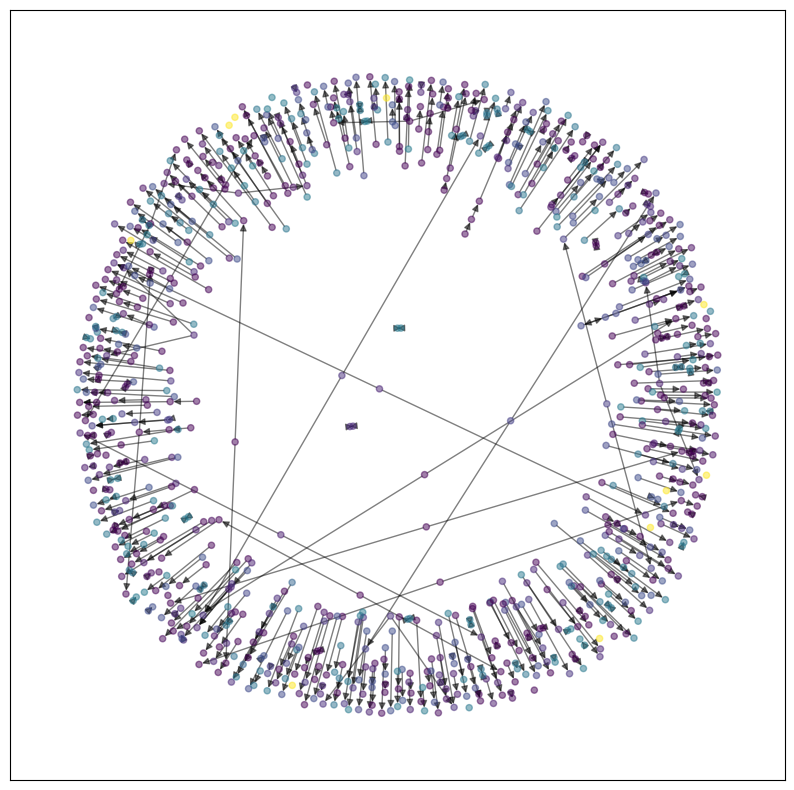

In [36]:
# plot the subgraph
H = G.subgraph(list(G.nodes())[:1000])

pos = nx.spring_layout(H)
colors = [node[1]['community'] for node in H.nodes(data=True)]
plt.figure(figsize=(10, 10))
nx.draw_networkx(H, pos, node_color=colors, node_size=20, alpha=0.5, with_labels=False)
plt.savefig('2-player_leiden_result.png', dpi=300)


#### Infomap

In [52]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from infomap import Infomap
import time
from openpyxl import Workbook

# Read the data
G = nx.read_gpickle('10000graph2.gpickle')

# Create a mapping from string nodes to integers
node_to_int = {node: i for i, node in enumerate(G.nodes)}
# Create a mapping from integers to string nodes for future reference
int_to_node = {i: node for node, i in node_to_int.items()}

# Use Infomap to perform community detection
start_time = time.time()
infomap_wrapper = Infomap("--two-level --directed --preferred-number-of-modules 10 --markov-time 1e-8")
for u, v, data in G.edges(data=True):
    weight = data.get('weight', 1.0)  # If the edges do not have weights, assign a default weight of 1.0
    infomap_wrapper.addLink(node_to_int[u], node_to_int[v], weight)
infomap_wrapper.run()
print("Community detection took %.2f seconds." % (time.time()-start_time))
community_detection_time = time.time() - start_time

# Obtain the mapping of communities to Elo scores
node_community_map = {int_to_node[node.physicalId]: node.moduleIndex() for node in infomap_wrapper.iterTree() if node.isLeaf()}
community_elo_map = {}
for node, community in node_community_map.items():
    community_elo_map.setdefault(community, []).append(G.nodes[node]['elo'])

# Calculate the variance of Elo scores for each community and sum them
variance_sum = sum(np.var(elo_list) for elo_list in community_elo_map.values())
print("The sum of variances of Elo scores in each community: ", variance_sum)
print(f'Total number of communities: {infomap_wrapper.numTopModules()}\n')

# Save the classification results of all players as an Excel file.
df = pd.DataFrame.from_dict(node_community_map, orient='index', columns=['Community'])
df.to_excel('2_player_leiden_result.xlsx', engine='openpyxl')

# Save the sum of variances, detection time, and the total number of communities to a text file.
with open("2_player_infomap_result.txt", "w") as f:
    f.write(f'Variance sum: {variance_sum}\n')
    f.write(f'Community detection time: {community_detection_time}\n')
    f.write(f'Total number of communities: {infomap_wrapper.numTopModules()}\n')


Community detection took 0.23 seconds.
The sum of variances of Elo scores in each community:  10147111.390715422
Total number of communities: 2849



#### Kmeans

In [168]:
import time
import numpy as np
import pandas as pd
from node2vec import Node2Vec
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import networkx as nx

# Calculate the start time
start_time = time.time()

# Read the data
G = nx.read_gpickle('10000graph2.gpickle')

# Generate node embeddings using node2vec
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=16)
model = node2vec.fit(window=10, min_count=1)

# Obtain the node embedding vectors.
node_embeddings = np.array([model.wv.get_vector(node) for node in G.nodes()])

# Perform clustering using KMeans.
kmeans = KMeans(n_clusters=4, random_state=42)  # You can modify the value of n_clusters to change the number of communities.
kmeans.fit(node_embeddings)
labels = kmeans.labels_

# Add the community labels of each node to the graph.
for i, node in enumerate(G.nodes()):
    G.nodes[node]['community'] = labels[i]


# Calculate the end time.
end_time = time.time()

# Calculate the variance of the Elo scores for each community.
elo_variances = []
for community in set(labels):
    elos = [data['elo'] for node, data in G.nodes(data=True) if data['community'] == community]
    elo_variances.append(np.var(elos))

print(f'Detection time: {end_time - start_time} seconds\n')
print(f'Number of communities: {len(set(labels))}\n')
print(f'The Mean of Elo variancey: {np.mean(elo_variances)}\n')

# Save the results to a text file.
with open('2_player_kmeans_result.txt', 'w') as f:
    f.write(f'Detection time: {end_time - start_time} seconds\n')
    f.write(f'Number of communities: {len(set(labels))}\n')
    f.write(f'The Mean of Elo variancey: {np.mean(elo_variances)}\n')

# Save the results to an Excel file.
players = list(G.nodes())
communities = [G.nodes[player]['community'] for player in players]
elos = [G.nodes[player]['elo'] for player in players]
df = pd.DataFrame({'Player': players, 'Community': communities, 'Elo': elos})
df.to_excel('2_player_kmeans_result.xlsx', index=False)


Computing transition probabilities:   0%|          | 0/12013 [00:00<?, ?it/s]

D:\ProgramData\anaconda3\envs\8021a3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Detection time: 34.57208609580994 seconds

Number of communities: 4

The Mean of Elo variancey: 134619.2131799861



#### DBSCAN

In [72]:
import time
import numpy as np
from node2vec import Node2Vec
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import networkx as nx

# Calculate the start time.
start_time = time.time()

# Generate node embeddings using node2vec.
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=16)
model = node2vec.fit(window=10, min_count=1)

# Obtain the node embedding vectors.
node_embeddings = np.array([model.wv.get_vector(node) for node in G.nodes()])

# Perform clustering using DBSCAN.
dbscan = DBSCAN(eps=1.5)  # You can modify the value of eps (epsilon) to change the clustering results.
labels = dbscan.fit_predict(node_embeddings)

# Add the community labels of each node to the graph.
for i, node in enumerate(G.nodes()):
    G.nodes[node]['community'] = labels[i]

# Calculate the end time.
end_time = time.time()

# Calculate the variance of the Elo scores for each community.
elo_variances = []
for community in set(labels):
    elos = [data['elo'] for node, data in G.nodes(data=True) if data['community'] == community]
    elo_variances.append(np.var(elos))

print(f'Detection time: {end_time - start_time} seconds\n')
print(f'Number of communities: {len(set(labels))}\n')
print(f'Average Elo variance per community: {np.mean(elo_variances)}\n')
# Save the results to a text file.
with open('2_player_DBSCAN_result.txt', 'w') as f:
    f.write(f'Detection time: {end_time - start_time} seconds\n')
    f.write(f'Number of communities: {len(set(labels))}\n')
    f.write(f'Average Elo variance per community: {np.mean(elo_variances)}\n')


Computing transition probabilities:   0%|          | 0/12013 [00:00<?, ?it/s]

Detection time: 35.35602903366089 seconds

Number of communities: 385

Average Elo variance per community: 4407.865803903434



#### Spectral Clustering

In [ ]:
from node2vec import Node2Vec
from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances
import pandas as pd
import numpy as np
import time

# Node2Vec模型设置
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=16)

# 训练Node2Vec模型
model = node2vec.fit(window=10, min_count=1)

# 提取节点嵌入
node_embeddings = np.array([model.wv.get_vector(node) for node in G.nodes])

# Spectral Clustering
start_time = time.time()
spectral_model = SpectralClustering(n_clusters=6, affinity='precomputed', n_init=100, assign_labels='discretize')
labels = spectral_model.fit_predict(pairwise_distances(node_embeddings, metric='cosine'))
end_time = time.time()

# 创建选手与其社区标签的映射
node_community_map = {list(G.nodes())[i]: label for i, label in enumerate(labels)}

# 将结果保存为Excel文件
df = pd.DataFrame(node_community_map.items(), columns=['Player', 'Community'])
df.to_excel('2_plauer_spectral_cluster_result.xlsx', index=False)

# 计算社区的数量，每个社区的Elo分数的平均方差
communities = set(labels)
elo_variances = [np.var([G.nodes[node]['elo'] for node in G.nodes if node_community_map[node] == community]) for community in communities]
avg_elo_variance = np.mean(elo_variances)

# 将运行时间和统计结果保存为文本文件
with open('2_player_spectral_cluster_result.txt', 'w') as f:
    f.write(f'Community detection time: {end_time - start_time}\n')
    f.write(f'Number of communities: {len(communities)}\n')
    f.write(f'Average Elo variance per community: {avg_elo_variance}\n')


#### Agglomerative Clustering

In [239]:
import time
import numpy as np
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
from sklearn.cluster import AgglomerativeClustering

# First, we need to create a Node2Vec model.
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=16)

# Train the Node2Vec model.
model = node2vec.fit(window=10, min_count=1)

# Retrieve the node vectors.
node_vectors = model.wv.vectors

# Initialize the hierarchical clustering model with the 'ward' linkage method, which is suitable for Euclidean distance. Assume there are approximately 5 communities.
ac = AgglomerativeClustering(n_clusters=5, linkage='ward')

# Start the timer.
start_time = time.time()

# Fit the model and make predictions.
labels = ac.fit_predict(node_vectors)

# Stop the timer.
end_time = time.time()

# Calculate the time taken for community detection.
detection_time = end_time - start_time

# Obtain the number of communities.
num_communities = np.unique(labels).shape[0]

# Create a DataFrame that includes the participants and their respective communities.
df = pd.DataFrame(list(zip(model.wv.index_to_key, labels)), columns=["Player", "Community"])

# Add the Elo scores to the DataFrame.
elo_scores = [G.nodes[node]['elo'] for node in model.wv.index_to_key]
df['Elo'] = elo_scores

# Save the DataFrame as an Excel file.
df.to_excel("2_player_Agglomerative_Clustering_result.xlsx", index=False)

# Calculate the variance of the average Elo scores for each community.
elo_variances = df.groupby('Community')['Elo'].var()

# Print and save the results.
print(f"Detection time: {detection_time}s\n")
print(f"Number of communities: {num_communities}\n")
print(f"Average Elo score variance per community: {elo_variances.mean()}\n")

with open("2_player_Agglomerative_Clustering_result.txt", "w") as f:
    f.write(f"Detection time: {detection_time}s\n")
    f.write(f"Number of communities: {num_communities}\n")
    f.write(f"Average Elo score variance per community: {elo_variances.mean()}\n")


Computing transition probabilities:   0%|          | 0/12013 [00:00<?, ?it/s]

Detection time: 5.359325885772705s

Number of communities: 5

Average Elo score variance per community: 115586.35063317833



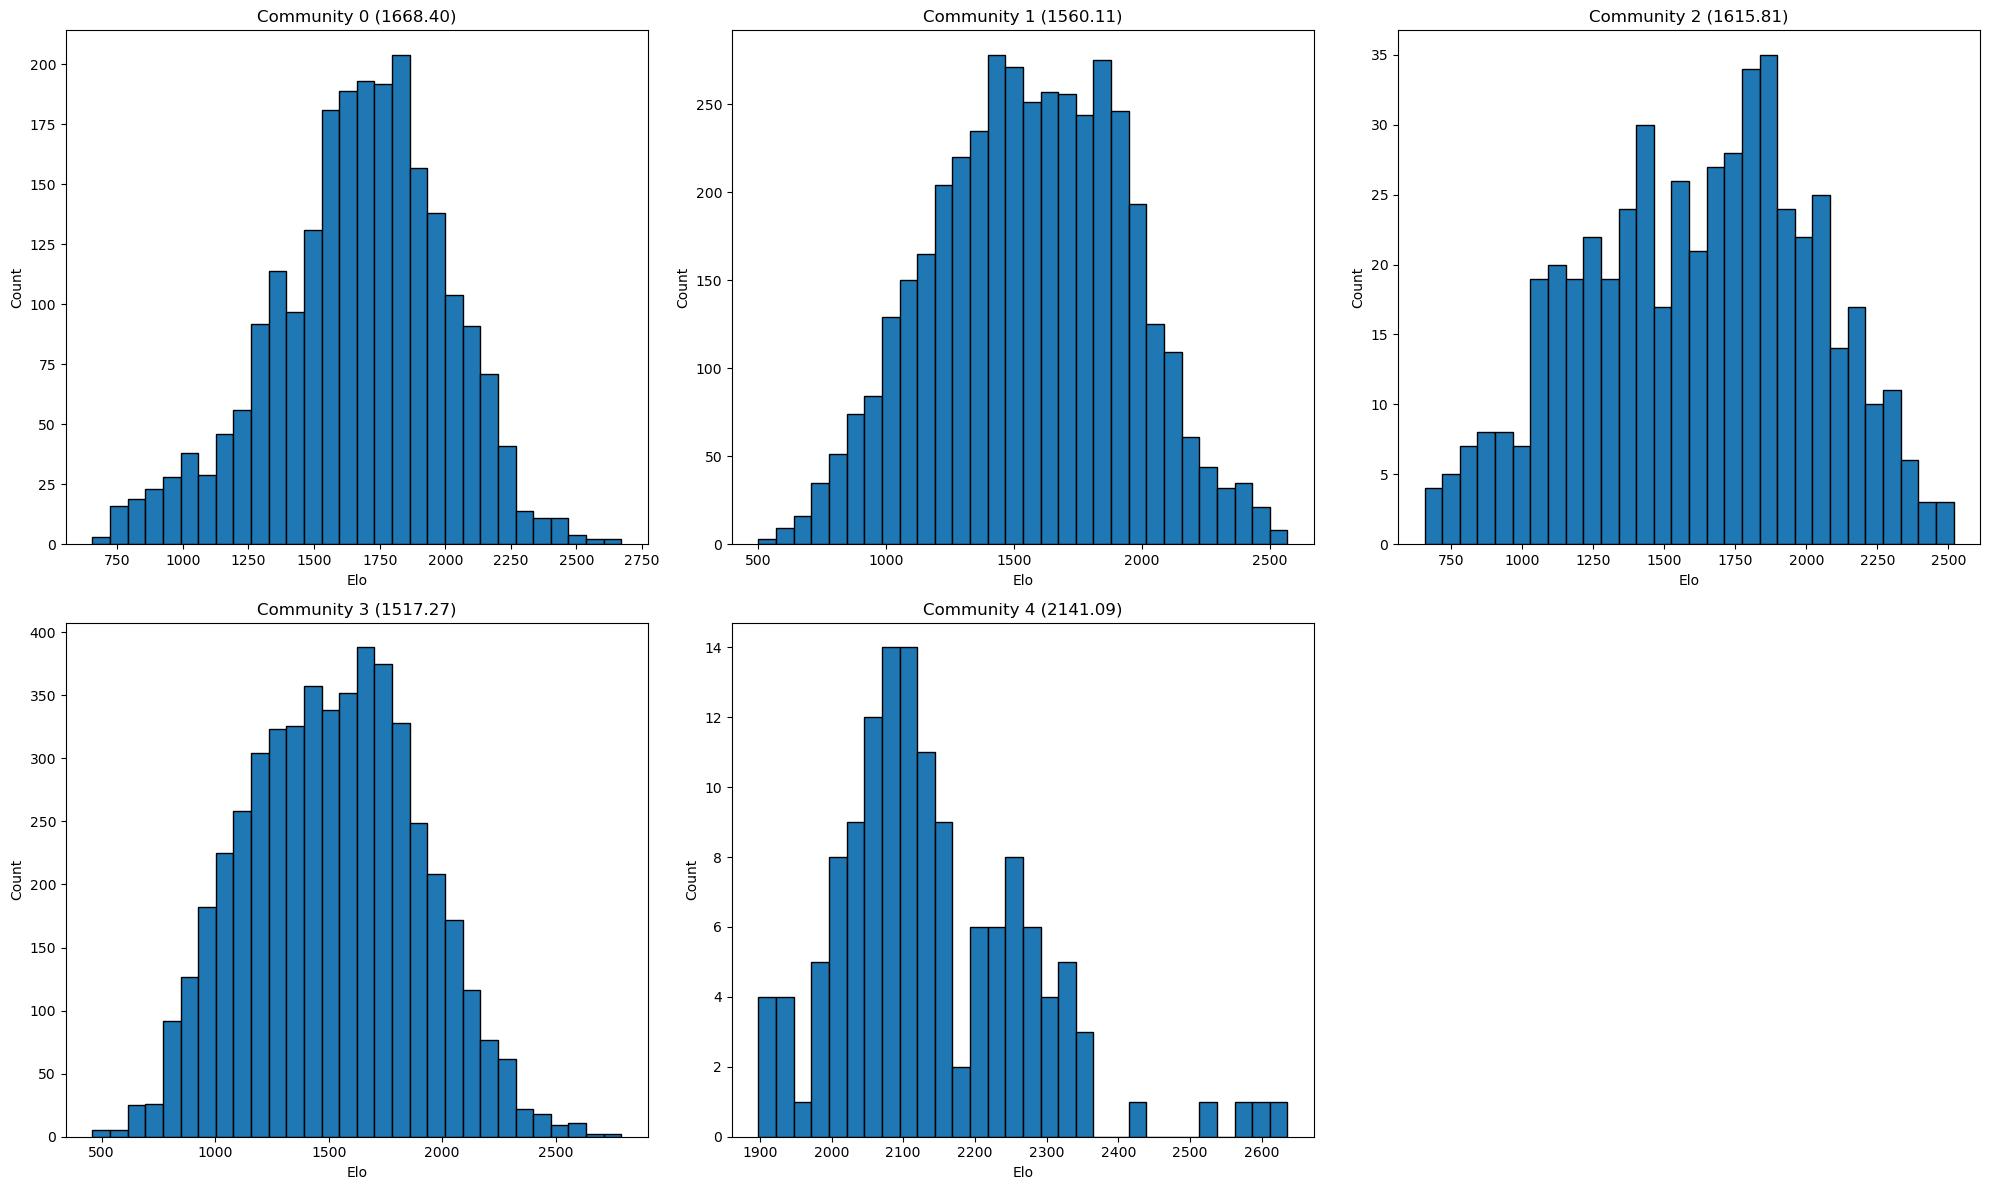

In [282]:
import pandas as pd
import matplotlib.pyplot as plt

# plot the results for community detection
df = pd.read_excel('2_player_Agglomerative_Clustering_result.xlsx')

grouped = df.groupby('Community')

n_rows = 2
n_cols = 3

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))

for i, (community, group) in enumerate(grouped):
    row = i // n_cols
    col = i % n_cols
    mean_elo = group['Elo'].mean()  
    axs[row, col].hist(group['Elo'], bins=30, edgecolor='black')
    axs[row, col].set_title(f'Community {community} ({mean_elo:.2f})')  
    axs[row, col].set_xlabel('Elo')
    axs[row, col].set_ylabel('Count')

if len(grouped) < n_rows * n_cols:
    for i in range(len(grouped), n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        fig.delaxes(axs[row, col])

plt.tight_layout()
plt.savefig('3-community.png', dpi=300)
plt.show()


## 2.2 Get the Best Strategies for Middle Games

### Construct the Graph for Matches between Different Communities

In [125]:
import pandas as pd
import networkx as nx
import numpy as np
import chess.pgn
import time

def generate_G(community1, community2):
    # Read Excel data
    score_df = pd.read_excel('100scores0.001.xlsx')
    transition_df = pd.read_excel('100scores0.001_change_points.xlsx')
    player_df = pd.read_excel('2_player_Agglomerative_Clustering_result.xlsx')  # Add this line to read player information

    transition_df.set_index('Series', inplace=True)
    player_df.set_index('Player', inplace=True)  # Set Player as the index for easy lookup

    s = time.time()

    # Create a directed graph
    G = nx.DiGraph()

    # Store the scores for each fen state across different games
    fen_scores = {}

    # Process each game
    for game_idx, game in enumerate(games):
        # Check the community; if it's not community 0 or 1, skip this game
        white = game.headers['White']
        black = game.headers['Black']
        if white not in player_df.index or black not in player_df.index:
            continue
        white_community = player_df.loc[white, 'Community']
        black_community = player_df.loc[black, 'Community']
        if white_community not in [community1, community2] or black_community not in [community1, community2]:
            continue

        # Obtain the fen state sequence from the game object
        board = game.board()
        fen_sequence = [board.fen()]
        for move in game.mainline_moves():
            board.push(move)
            fen_sequence.append(board.fen())

        # Get the change points
        if 'game_'+str(game_idx+1) in transition_df.index and not transition_df.loc['game_'+str(game_idx+1)].isna().any():
            transition_points = transition_df.loc['game_'+str(game_idx+1)]
        else:
            continue  # Skip games with missing data

        # Determine the stage of each fen state
        for i, fen in enumerate(fen_sequence):
            if i == 0:
                stage = '0'
            elif i < transition_points['Transition Point 1']:
                stage = '1'
            elif i < transition_points['Transition Point 2']:
                stage = '2'
            elif i < len(fen_sequence) - 1:
                stage = '3'
            else:
                stage = '4'

            # Modify the 'who' field here, changing player names to their respective communities
            who = white_community if i % 2 == 0 else black_community

            # Update the scores for the fen state across different games
            if i < len(score_df):
                score = score_df.loc[i, 'game_'+str(game_idx+1)]
            else:
                continue  # Skip steps not present in score_df

            if np.isnan(score):
                continue

            if fen not in fen_scores:
                fen_scores[fen] = [score]
            else:
                fen_scores[fen].append(score)

            # Calculate the winning condition
            avg_score = np.mean(fen_scores[fen])
            win = 1 if avg_score > 200 else 0

            # If the fen state is not in the graph, create a new node
            if fen not in G.nodes:
                G.add_node(fen, win=win, cat=stage, who=who)
            else:  # Otherwise, update the node's winning condition
                G.nodes[fen]['win'] = win

            # If not the first step, create an edge from the previous fen state to the current one, and update the weight
            if i > 0:
                prev_fen = fen_sequence[i - 1]
                if G.has_edge(prev_fen, fen):
                    G[prev_fen][fen]['weight'] += 1
                else:
                    G.add_edge(prev_fen, fen, weight=1)

    # Check and remove nodes without all attributes
    nodes_to_remove = []
    for node in G.nodes(data=True):
        if 'win' not in node[1] or 'cat' not in node[1] or 'who' not in node[1]:
            nodes_to_remove.append(node[0])

    for node in nodes_to_remove:
        G.remove_node(node)

    during = time.time()-s
    print(during/len(games))
    nx.write_gpickle(G, f'100graph3_{community1}_{community2}.gpickle')
    
    return G


### Node2vec

In [128]:
import time
import networkx as nx
import pandas as pd
import numpy as np
from node2vec import Node2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

def generate_features(community1, community2):
    s = time.time()

    # Load the graph.
    G = nx.read_gpickle(f'100graph3_{community1}_{community2}.gpickle')

    # Initialize the Node2Vec model.
    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=16)

    # Train the Node2Vec model.
    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    print(time.time()-s)

    # Obtain the vector representations of the nodes.
    nodes = [x for x in G.nodes(data=True)]
    node_ids = [x[0] for x in nodes]
    node_features = np.array([model.wv[x] for x in node_ids])

    # Construct the data.
    df = pd.DataFrame(node_features, index=node_ids)
    for node_id, node_data in nodes:
        if 'who' in node_data:
            df.loc[node_id, 'who'] = node_data['who']
        if 'cat' in node_data:
            df.loc[node_id, 'cat'] = node_data['cat']
        if 'win' in node_data:
            df.loc[node_id, 'win'] = node_data['win']


    df.to_excel(f'3_100graph3_{community1}_{community2}.xlsx')


### Random Forest

In [130]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import time
import torch

def rf_output(community1, community2):
    # Read the data.
    df = pd.read_excel(f'3_100graph3_{community1}_{community2}.xlsx', index_col=0)

    # Perform one-hot encoding on the "cat" column.
    cat_ohe = OneHotEncoder(drop='first', sparse=False)
    cat_encoded = cat_ohe.fit_transform(df[['cat']])
    cat_encoded_df = pd.DataFrame(cat_encoded, columns=[f'cat_{cat}' for cat in range(1, 5)], index=df.index)

    # Merge the encoded "cat" data with the original data.
    df = pd.concat([df, cat_encoded_df], axis=1)

    # Extract features and targets.
    X = df.drop(columns=['win', 'cat'])
    y = df['win']
    cat_data = df['cat']  
    who_data = df['who']

    # Convert all feature names to strings.
    X.columns = X.columns.astype(str)

    # Split the data into training and testing sets.
    X_train, X_test, y_train, y_test, cat_train, cat_test, who_train, who_test = train_test_split(X, y, cat_data, who_data, test_size=0.2, random_state=42)

    # Create and train the model.
    model = RandomForestClassifier(n_jobs=-1, random_state=42)
    start = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start

    # Calculate the prediction results on the testing set.
    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict_proba(X_test)[:, 1]

    # Prepare a DataFrame for the results.
    results = pd.DataFrame({
        'who': pd.concat([df['who'].loc[X_train.index], df['who'].loc[X_test.index]]),
        'win_probability': np.concatenate([y_train_pred, y_test_pred]),
        'cat': pd.concat([df['cat'].loc[X_train.index], df['cat'].loc[X_test.index]]),
        'is_test': np.concatenate([np.zeros(len(y_train), dtype=int), np.ones(len(y_test), dtype=int)])
    })

    # Save the results to an Excel file.
    results.to_excel(f'3_node_random_forest_result_{community1}_{community2}.xlsx')

    # Calculate the accuracy of the training and testing sets.
    train_acc = accuracy_score(y_train, y_train_pred > 0.5)
    test_acc = accuracy_score(y_test, y_test_pred > 0.5)

    # Calculate the classification report for the training and testing sets.
    train_report = classification_report(y_train, y_train_pred > 0.5)
    test_report = classification_report(y_test, y_test_pred > 0.5)

    print(f"Train Accuracy: {train_acc}\n")
    print(f"Test Accuracy: {test_acc}\n")
    print(f"Training Time: {training_time} seconds\n")

    print("Train Classification Report:\n", train_report)
    print("Test Classification Report:\n", test_report)

    # Save the results to a text file.
    with open(f'3_node_random_forest_result_{community1}_{community2}.txt', 'w') as f:
        f.write(f"Train Accuracy: {train_acc}\n")
        f.write(f"Test Accuracy: {test_acc}\n")
        f.write(f"Training Time: {training_time} seconds\n")

        f.write("Train Classification Report:\n")
        f.write(train_report)

        f.write("Test Classification Report:\n")
        f.write(test_report)


### Get the Best Strategies

In [258]:
import pandas as pd
import networkx as nx
import numpy as np

def final_result(community1, community2):
    # Load graph
    G = nx.read_gpickle(f'100graph3_{community1}_{community2}.gpickle')

    # Load data
    df = pd.read_excel(f'3_node_random_forest_result_{community1}_{community2}.xlsx')
    df.columns = ['node', 'who', 'win_probability', 'cat', 'is_test']

    # Filter 'cat' = 2 nodes and compute degree centrality
    df2 = df[df['cat'] == 2]
    degree_centrality = dict(G.degree(df2['node']))
    df2['degree_centrality'] = df2['node'].map(degree_centrality)

    # Get top 5 'who' = 0 and 'who' = 1 nodes
    top_nodes_0 = df2[df2['who'] == 0].nlargest(5, 'degree_centrality')['node'].tolist()
    top_nodes_1 = df2[df2['who'] == 1].nlargest(5, 'degree_centrality')['node'].tolist()

    # Define function to find node with max 'win_probability' among successors' successors for each successor
    def find_max_win_prob_node(node):
        successors = list(G.successors(node))
        max_win_prob_successors = []
        for succ in successors:
            succ_successors = list(G.successors(succ))
            if len(succ_successors) == 0:
                continue
            df_subset = df.set_index('node').loc[succ_successors]['win_probability']
            max_win_prob_successors.append((node, succ, df_subset.idxmax(), df_subset.max()))
        return max_win_prob_successors

    # Prepare results
    results_list = []
    for top_node in top_nodes_0 + top_nodes_1:
        who = 0 if top_node in top_nodes_0 else 1
        max_win_prob_successors = find_max_win_prob_node(top_node)
        results_node = pd.DataFrame(max_win_prob_successors, columns=['node', 'successor', 'max_win_prob_node', 'max_win_prob'])
        results_node['who'] = who
        results_list.append(results_node)

    if len(results_list) == 0:
        print('no results')
    else:
        results = pd.concat(results_list)

        # Save results to file
        results.to_excel(f'3_result_{community1}_{community2}.xlsx', index=False)



In [259]:
import itertools

categories = [0, 1, 2, 3, 4]

combinations = itertools.combinations(categories, 2)

# combinations = [(0,1),(0,2),(0,3),(0,4),(1,2),(1,3),(1,4),(2,3),(2,4),(3,4)]

# combinations = [(2,4),(3,4)]

for combo in combinations:
    G = generate_G(combo[0], combo[1])
    generate_features(combo[0], combo[1])
    rf_output(combo[0], combo[1])
    final_result(combo[0], combo[1])


0.00022490768432617187


Computing transition probabilities:   0%|          | 0/292 [00:00<?, ?it/s]

49.060659885406494


D:\ProgramData\anaconda3\envs\8021a3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
D:\ProgramData\anaconda3\envs\8021a3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\anaconda3\envs\8021a3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\anaconda3\envs\8021a3\lib\site-packages\sklear

Train Accuracy: 1.0

Test Accuracy: 0.6101694915254238

Training Time: 0.15279555320739746 seconds

Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       170
           1       1.00      1.00      1.00        63

    accuracy                           1.00       233
   macro avg       1.00      1.00      1.00       233
weighted avg       1.00      1.00      1.00       233

Test Classification Report:
               precision    recall  f1-score   support

           0       0.61      1.00      0.76        36
           1       0.00      0.00      0.00        23

    accuracy                           0.61        59
   macro avg       0.31      0.50      0.38        59
weighted avg       0.37      0.61      0.46        59

no results
0.0015222209215164184


Computing transition probabilities:   0%|          | 0/2523 [00:00<?, ?it/s]

390.94459104537964


D:\ProgramData\anaconda3\envs\8021a3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Train Accuracy: 1.0

Test Accuracy: 0.7722772277227723

Training Time: 0.2509880065917969 seconds

Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1494
           1       1.00      1.00      1.00       524

    accuracy                           1.00      2018
   macro avg       1.00      1.00      1.00      2018
weighted avg       1.00      1.00      1.00      2018

Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.97      0.87       398
           1       0.28      0.05      0.08       107

    accuracy                           0.77       505
   macro avg       0.53      0.51      0.48       505
weighted avg       0.68      0.77      0.70       505

no results


C:\Users\Shawn\AppData\Local\Temp\ipykernel_25076\3878627793.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['degree_centrality'] = df2['node'].map(degree_centrality)
